# Pankreopriver diabetes mellitus vs Diabetes Type 1 

## Beta diversity

### Libraries

In [1]:
# pd.options.display.max_columns= 999

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [5]:
from skbio.stats.ordination import pcoa

In [6]:
from skbio.stats.distance import DistanceMatrix

In [7]:
from skbio.stats.distance import _permanova

### Data loading

In [8]:
df = pd.read_csv(
    "/data/projects/2024/Effenberger-Diabetes/data/PDM merged 3.0_modified.csv"
)

In [9]:
sample_info = pd.read_csv(
    "/data/projects/2024/Effenberger-Diabetes/data/20011/20011_SampleInfo.csv"
)

In [10]:
df.rename(columns={"Probennummer": "sample_information"}, inplace=True)

In [11]:
sample_info.rename(columns={"SampleInformation": "sample_information"}, inplace=True)

In [12]:
df = df.merge(
    sample_info[["sample_information", "IMGM ID", "Type"]],
    on="sample_information",
    how="left",
)

In [13]:
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/barplot/level-6.csv"
df_tax = pd.read_csv(file_path)

In [14]:
df_tax.set_index("index", inplace=True)

In [15]:
exclude_cols = [
    "sample_information",
    "age",
    "KHK1",
    "KHK2",
    "CA1",
    "CA2",
    "HbA1C (DCCT/NGSP)1",
    "HbA1C (DCCT/NGSP)2",
    "Glukose1",
    "Glukose2",
    "BMI1",
    "BMI2",
    "Pankreatektomie",
    "HbA1C_diff",
    "Glukose_diff",
    "BMI_diff",
    "KHK_diff",
    "CA_diff",
]

df_tax_bacteria = df_tax.drop(columns=exclude_cols, errors="ignore")

threshold = 0.1

mean_abundance = df_tax_bacteria.mean(axis=0)

low_abundance_taxa = mean_abundance[mean_abundance < threshold].index

df_low_abundance = df_tax_bacteria[low_abundance_taxa]

high_abundance_taxa = mean_abundance[mean_abundance >= threshold].index

df_high_abundance = df_tax_bacteria[high_abundance_taxa]

In [16]:
#file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/diversity/beta_diversity/bray_curtis_distance_matrix-condition/raw_data.tsv"
file_path = "/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/bray_curtis_raw_data.tsv"

bray_curtis = pd.read_csv(file_path, sep="\t")
bray_curtis = bray_curtis.iloc[:, 1:]

In [17]:
#file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/diversity/beta_diversity/jaccard_distance_matrix-condition/raw_data.tsv"
file_path = "/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/jaccard_raw_data.tsv"
jaccard = pd.read_csv(file_path, sep="\t")
jaccard = jaccard.iloc[:, 1:]

In [18]:
jaccard.head()

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,s20011_0005,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.958784
1,s20011_0009,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.966202
2,s20011_0009,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.955776
3,s20011_0010,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.970096
4,s20011_0010,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.971220


In [19]:
bray_curtis.head()

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,s20011_0005,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.868272
1,s20011_0009,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.826948
2,s20011_0009,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.780646
3,s20011_0010,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.870818
4,s20011_0010,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.883088


### Data cleaning

#### Metadata contains clinical information

In [20]:
metadata_cols = df[
    [
        "IMGM ID",
        "sample_information",
        "Type",
        "age",
        "KHK1",
        "KHK2",
        "CA1",
        "CA2",
        "HbA1C (DCCT/NGSP)1",
        "HbA1C (DCCT/NGSP)2",
        "Glukose1",
        "Glukose2",
        "BMI1",
        "BMI2",
        "Pankreatektomie",
        "sex",
        "Insulin1",
        "Insulin2",
        "MASLD1",
        "MASLD2",
        "nikotin",
    ]
]

In [21]:
metadata = metadata_cols.dropna(subset=["IMGM ID"])

In [22]:
metadata["HbA1C_diff"] = metadata.apply(
    lambda x: (
        "increase"
        if x["HbA1C (DCCT/NGSP)2"] - x["HbA1C (DCCT/NGSP)1"] > 0
        else "decrease"
    ),
    axis=1,
)
metadata["Glukose_diff"] = metadata.apply(
    lambda x: "increase" if x["Glukose2"] - x["Glukose1"] > 0 else "decrease", axis=1
)
metadata["BMI_diff"] = metadata.apply(
    lambda x: "increase" if x["BMI2"] - x["BMI1"] > 0 else "decrease", axis=1
)

In [23]:
def categorize_diff(before, after):
    if after == "ja" and before == "nein":
        return "onset"
    elif after == "nein" and before == "nein":
        return "absent"
    elif after == "nein" and before == "ja":
        return "resolved"
    elif after == "ja" and before == "ja":
        return "persistent"
    else:
        return "unknown"


metadata["KHK_diff"] = metadata.apply(
    lambda x: categorize_diff(x["KHK1"], x["KHK2"]), axis=1
)
metadata["CA_diff"] = metadata.apply(
    lambda x: categorize_diff(x["CA1"], x["CA2"]), axis=1
)

In [24]:
metadata.rename(columns={"IMGM ID": "id"}, inplace=True)

In [25]:
metadata_k = metadata[metadata["sample_information"].str.contains("K", na=False)]
metadata_dm = metadata[metadata["sample_information"].str.match("DM", na=False)]
metadata_pdm = metadata[metadata["sample_information"].str.contains("PDM", na=False)]

In [26]:
metadata_k = metadata_k.drop_duplicates(subset=["id"], keep="first")
metadata_dm = metadata_dm.drop_duplicates(subset=["id"], keep="first")
metadata_pdm = metadata_pdm.drop_duplicates(subset=["id"], keep="first")

In [27]:
metadata = metadata.drop_duplicates(subset=["id"], keep="first")

#### Microbial data contains taxonomic information from QUIIME

In [28]:
microbial_data = df_high_abundance.drop(columns=metadata_cols, errors="ignore")

In [29]:
microbial_data["id"] = microbial_data.index

In [30]:
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(";")[-1].strip()

In [31]:
microbial_data.rename(
    columns={col: extract_species_name(col) for col in microbial_data.columns},
    inplace=True,
)

In [32]:
microbial_data.rename(columns={"index": "id"}, inplace=True)

In [33]:
microbial_data.columns = microbial_data.columns.str.strip()
metadata.columns = metadata.columns.str.strip()

print("microbial_data columns:", microbial_data.columns)
print("metadata columns:", metadata.columns)

if "id" in microbial_data.columns and "id" in metadata.columns:
    microbial_data = microbial_data.merge(
        metadata[
            [
                "id",
                "Type",
                "sample_information",
                "age",
                "KHK1",
                "KHK2",
                "CA1",
                "CA2",
                "HbA1C (DCCT/NGSP)1",
                "HbA1C (DCCT/NGSP)2",
                "Glukose1",
                "Glukose2",
                "Pankreatektomie",
                "BMI1",
                "BMI2",
            ]
        ],
        on="id",
        how="left",
    )

else:
    print("'id' column not found in one or both DataFrames.")

microbial_data columns: Index(['', '', '', 'Bacteroides', 'Fusicatenibacter', 'Ruminococcus',
       'Subdoligranulum', 'Prevotella_9', '', '',
       ...
       'Aeromonas', 'CHKCI001', 'DNF00809', 'Succiniclasticum', 'Anaerococcus',
       '', 'Caproiciproducens', '', 'Lachnospiraceae UCG-009', 'id'],
      dtype='object', length=354)
metadata columns: Index(['id', 'sample_information', 'Type', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
       'BMI1', 'BMI2', 'Pankreatektomie', 'sex', 'Insulin1', 'Insulin2',
       'MASLD1', 'MASLD2', 'nikotin', 'HbA1C_diff', 'Glukose_diff', 'BMI_diff',
       'KHK_diff', 'CA_diff'],
      dtype='object')


In [34]:
ordinal_map = {
    "nein": 0,
    "Teilresektion links": 1,
    "Teilresektion rechts": 2,
    "Resektion": 3,
}

microbial_data["Pankreatektomie_encoded"] = microbial_data["Pankreatektomie"].map(
    ordinal_map
)

In [35]:
microbial_data_original = microbial_data.copy()

In [36]:
microbial_data = microbial_data.drop(columns=["Pankreatektomie"])

In [37]:
jaccard.head()

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,s20011_0005,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.958784
1,s20011_0009,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.966202
2,s20011_0009,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.955776
3,s20011_0010,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.970096
4,s20011_0010,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.971220


#### PCoA - Beta diversity - Jaccard distance 

In [38]:
df = jaccard

In [39]:
df["Group1"].replace("Diabetes mellitus Typ1", "DM", inplace=True)
df["Group1"].replace("pankreopriver Diabetes", "PDM", inplace=True)
df["Group1"].replace("Kontrolle", "K", inplace=True)
df["Group2"].replace("Diabetes mellitus Typ1", "DM", inplace=True)
df["Group2"].replace("pankreopriver Diabetes", "PDM", inplace=True)
df["Group2"].replace("Kontrolle", "K", inplace=True)

/tmp/ipykernel_3563385/2979948837.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Group1"].replace("Diabetes mellitus Typ1", "DM", inplace=True)
/tmp/ipykernel_3563385/2979948837.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [40]:
jaccard["PairType"] = jaccard.apply(
    lambda row: (
        f"{row['Group1']} vs {row['Group2']}"
        if row["Group1"] <= row["Group2"]
        else f"{row['Group2']} vs {row['Group1']}"
    ),
    axis=1,
)

In [41]:
import pandas as pd
from scipy.spatial.distance import squareform

long_df = jaccard.copy()
dist_matrix = pd.pivot_table(
    long_df, index="SubjectID1", columns="SubjectID2", values="Distance"
)

dist_matrix = dist_matrix.combine_first(dist_matrix.T).fillna(0)

In [42]:
pcoa_results = pcoa(dist_matrix)
pcoa_df = pcoa_results.samples

In [43]:
pcoa_df.index = dist_matrix.index

In [44]:
pcoa_df["id"] = pcoa_df.index

In [45]:
pcoa_df = pcoa_df.merge(
    metadata[["id", "Type", "sample_information"]], on="id", how="left"
)

In [46]:
pcoa_df["Type"] = pcoa_df["Type"].replace(
    {"Kontrolle": "K", "Diabetes mellitus Typ1": "DM", "pankreopriver Diabetes": "PDM"}
)

/tmp/ipykernel_3563385/2757697049.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}%)")
/tmp/ipykernel_3563385/2757697049.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}%)")
/tmp/ipykernel_3563385/2757697049.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_zlabel(f"PC3 ({pcoa_resu

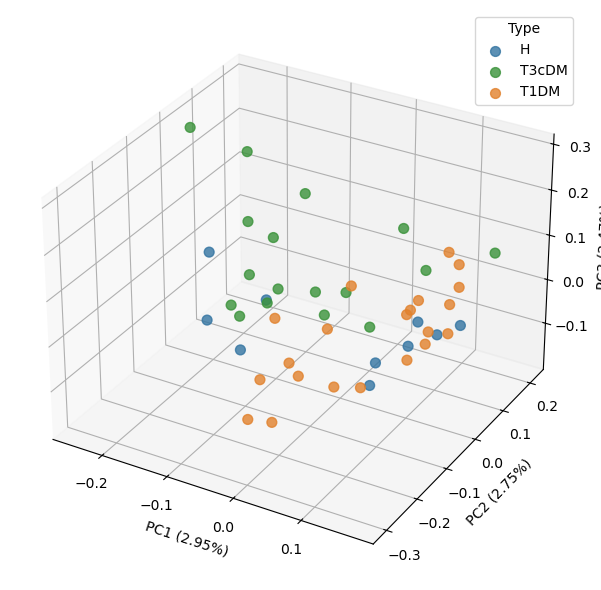

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


pcoa_df["Type"] = pcoa_df["Type"].replace({
    "K": "H",
    "DM": "T1DM",
    "PDM": "T3cDM"
})


custom_palette = {
    "H": "#3374A1",
    "T1DM": "#E1812C",
    "T3cDM": "#3A923A"
}

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

for group in pcoa_df["Type"].unique():
    subset = pcoa_df[pcoa_df["Type"] == group]
    ax.scatter(
        subset["PC1"],
        subset["PC2"],
        subset["PC3"],
        label=group,
        color=custom_palette.get(group, "gray"),
        s=50,
        alpha=0.8,
    )

ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}%)")
ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}%)")
ax.set_zlabel(f"PC3 ({pcoa_results.proportion_explained[2]*100:.2f}%)")
ax.set_title("")

ax.legend(title="Type")
plt.tight_layout()


#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/jaccard_pcoa_3d.svg", dpi=300)
#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/jaccard_pcoa_3d.png", dpi=300)

plt.show()


In [48]:
#pcoa_df.to_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/supplementary_tables/jaccard_pcoa_3d.csv")

#### PCoA - Beta diversity - Bray Curtis distance 

In [49]:
bray_curtis["PairType"] = bray_curtis.apply(
    lambda row: (
        f"{row['Group1']} vs {row['Group2']}"
        if row["Group1"] <= row["Group2"]
        else f"{row['Group2']} vs {row['Group1']}"
    ),
    axis=1,
)

In [50]:
import pandas as pd
from scipy.spatial.distance import squareform

long_df = bray_curtis.copy()
dist_matrix = pd.pivot_table(
    long_df, index="SubjectID1", columns="SubjectID2", values="Distance"
)

dist_matrix = dist_matrix.combine_first(dist_matrix.T).fillna(0)

In [51]:
pcoa_results = pcoa(dist_matrix)
pcoa_df = pcoa_results.samples

In [52]:
pcoa_df.index = dist_matrix.index

In [53]:
pcoa_df["id"] = pcoa_df.index

In [54]:
pcoa_df = pcoa_df.merge(
    metadata[["id", "Type", "sample_information"]], on="id", how="left"
)

In [55]:
pcoa_df["Type"] = pcoa_df["Type"].replace(
    {"Kontrolle": "K", "Diabetes mellitus Typ1": "DM", "pankreopriver Diabetes": "PDM"}
)

/tmp/ipykernel_3563385/828497007.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}%)")
/tmp/ipykernel_3563385/828497007.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}%)")
/tmp/ipykernel_3563385/828497007.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_zlabel(f"PC3 ({pcoa_results

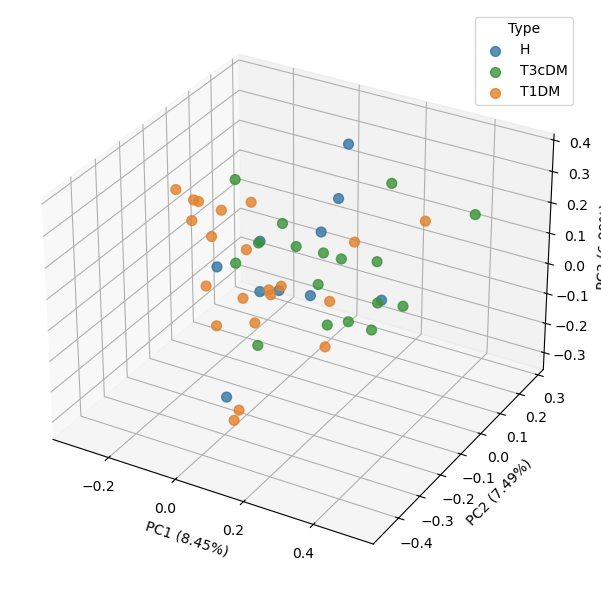

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


pcoa_df["Type"] = pcoa_df["Type"].replace({
    "K": "H",
    "DM": "T1DM",
    "PDM": "T3cDM"
})


custom_palette = {
    "H": "#3374A1",
    "T1DM": "#E1812C",
    "T3cDM": "#3A923A"
}


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

for group in pcoa_df["Type"].unique():
    subset = pcoa_df[pcoa_df["Type"] == group]
    ax.scatter(
        subset["PC1"],
        subset["PC2"],
        subset["PC3"],
        label=group,
        color=custom_palette.get(group, "gray"),
        s=50,
        alpha=0.8,
    )

ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}%)")
ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}%)")
ax.set_zlabel(f"PC3 ({pcoa_results.proportion_explained[2]*100:.2f}%)")
ax.set_title("")


#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/bray_curtis_pcoa_3d.svg", dpi = 300)
#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/bray_curtis_pcoa_3d.png",dpi = 300)

# Add legend and layout
ax.legend(title="Type")
plt.tight_layout()
plt.show()

In [57]:
#pcoa_df.to_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/supplementary_tables/bray_curtis_pcoa_3d.csv")